In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import os, sys
from glob import glob
from collections import Counter
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer

/tmp/ipykernel_862817/68159679.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# confusion matrix and RoC RNA002

### ROC & Precision-Recall Curve

- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py


98827 Counter({3: 40957, 2: 22625, 4: 19550, 1: 15695})
(100000, 5)
(99902, 8)


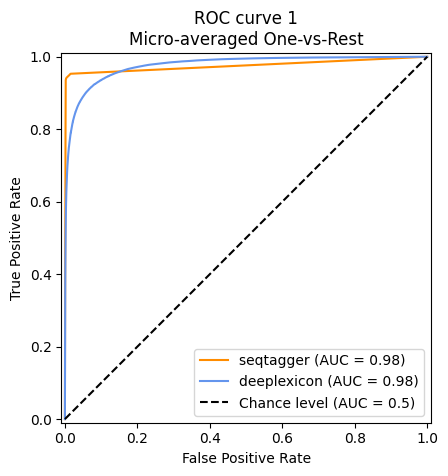

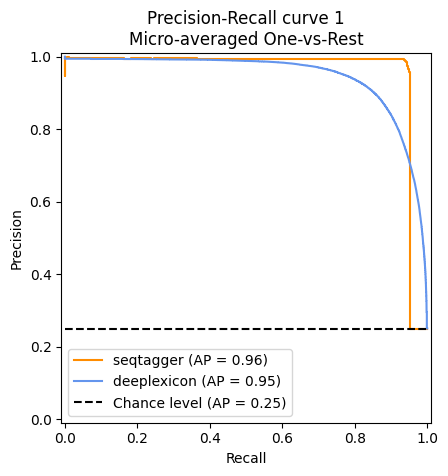

In [52]:
ref2bc = {'cc6m_2244_T7_ecorv': 1,
 'cc6m_2459_T7_ecorv': 2,
 'cc6m_2595_T7_ecorv': 3,
 'cc6m_2709_T7_ecorv': 4}

i = 1 # 1 2 3
ext = "svg"
bams = ["/no_backup/enovoa/nextflow_outputs/demux_comparison/results/ground_truth_fast5_pass_100k_batch{}/alignment/fast5_pass_100k_batch{}_s.bam".format(i, i), 
       ]; bams

read2bc = {}
for bi, bam in enumerate(bams, 1):
    sys.stderr.write(" %s / %s \r"%(bi, len(bams)))
    sam = pysam.AlignmentFile(bam)
    for a in sam:
        if a.is_secondary or a.mapq<20 or a.is_supplementary: #
            continue
        r, ref = a.qname, a.reference_name
        #if r not in read2ref: read2ref[r] = [(a.mapq, a.reference_name)]
        if ref not in ref2bc: continue
        read2bc[r] = ref2bc[ref]
print(len(read2bc), Counter(read2bc.values()))

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

# seqtagger
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/seqtagger_std_fast5_pass_100k_batch{}/demux_table/seqtagger_std_sample{}.txt"
df = pd.read_csv(fn.format(i, i), sep="\t"); print(df.shape)

y_score = np.zeros((len(df), 4)); y_score.shape
for _i, (bc, score) in enumerate(zip(df.barcode.to_numpy(), df.baseQ.to_numpy())):
    y_score[_i, bc-1] = score
y_test = np.array([read2bc[r] if r in read2bc else 0 for r in df.read_id.to_numpy()]); y_test
y_score = y_score[y_test>0]
y_test = y_test[y_test>0]; y_test.shape, y_score.shape
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test); y_onehot_test

display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="seqtagger", color="darkorange", 
                                           plot_chance_level=False, ax=ax)
display = PrecisionRecallDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="seqtagger", color="darkorange", 
                                                  plot_chance_level=False, ax=ax2)

# deeplexicon
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/deeplexicon_std_fast5_pass_100k_batch{}/demux_table/deeplexicon_std_sample{}.txt"
df = pd.read_csv(fn.format(i, i), sep="\t"); print(df.shape)

y_score = df[df.columns[-4:]].to_numpy(); y_score
y_test = np.array([read2bc[r] if r in read2bc else 0 for r in df.ReadID.to_numpy()]); y_test
y_score = y_score[y_test>0]
y_test = y_test[y_test>0]; y_test.shape, y_score.shape
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test); y_onehot_test

display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="deeplexicon", color="cornflowerblue", 
                                           plot_chance_level=True, ax=ax)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
                    title="ROC curve {}\nMicro-averaged One-vs-Rest".format(i, len(y_score)))
fig = display.figure_
fig.savefig("both.{}.ROC.{}".format(i, ext))
fig.savefig("both.{}.ROC.pdf".format(i))

display = PrecisionRecallDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="deeplexicon", color="cornflowerblue", 
                                                  plot_chance_level=True, ax=ax2) # True
_ = display.ax_.set(xlabel="Recall", ylabel="Precision", 
                    title="Precision-Recall curve {}\nMicro-averaged One-vs-Rest".format(i, len(y_score)))

fig2.savefig("both.{}.Precision-Recall.{}".format(i, ext))
fig2.savefig("both.{}.Precision-Recall.pdf".format(i))

## seqtagger

In [53]:
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/seqtagger_std_fast5_pass_100k_batch{}/demux_table/seqtagger_std_sample{}.txt"
df = pd.read_csv(fn.format(i, i), sep="\t")

minbaseQ = 50
n = int(df.barcode.max())
cm = np.zeros((n, n), dtype='int')
for idx, r in df.loc[df.baseQ>=minbaseQ].iterrows():
    if r.read_id not in read2bc: continue
    if np.isnan(r.barcode): continue
    cm[read2bc[r.read_id]-1, int(r.barcode-1)] += 1
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc, cm

(0.99,
 array([[14657,   172,   116,    54],
        [   48, 20749,    32,    22],
        [   47,    81, 39733,    31],
        [   35,   220,    76, 17708]]))

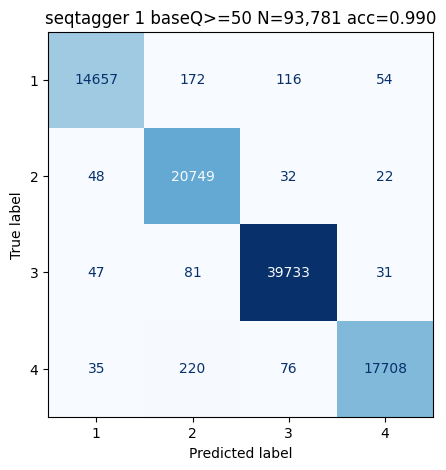

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
sel = np.any((cm.sum(axis=0)!=0, cm.sum(axis=1)!=0), axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[sel][:,sel], 
                              display_labels=np.arange(1, len(cm)+1)[sel])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
runid = os.path.basename(fn)
title = "seqtagger {} baseQ>={} N={:,} acc={:.3f}".format(i, minbaseQ, cm.sum(), acc)
ax.set_title(title)
fig.savefig("seqtagger.{}.confusion_matrix.{}".format(i, ext))

In [55]:
bc2c = Counter(read2bc.values()); bc2c
c = np.array([[bc2c[k] for k in sorted(bc2c.keys())]]); c.T
missing = c-cm.sum(axis=1)
cm_with_missing = np.hstack((cm, missing.T))
np.savetxt(sys.stdout, cm_with_missing, fmt="%d", delimiter="\t")

14657	172	116	54	696
48	20749	32	22	1774
47	81	39733	31	1065
35	220	76	17708	1511


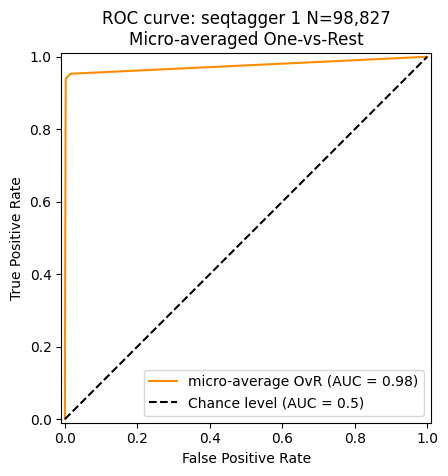

In [59]:
y_score = np.zeros((len(df), 4)); y_score.shape
for _i, (bc, score) in enumerate(zip(df.barcode.to_numpy(), df.baseQ.to_numpy())):
    y_score[_i, bc-1] = score
y_test = np.array([read2bc[r] if r in read2bc else 0 for r in df.read_id.to_numpy()]); y_test
y_score = y_score[y_test>0]
y_test = y_test[y_test>0]; y_test.shape, y_score.shape
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test); y_onehot_test

display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="micro-average OvR", color="darkorange", plot_chance_level=True)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
                    title="ROC curve: seqtagger {} N={:,}\nMicro-averaged One-vs-Rest".format(i, len(y_score)))
fig = display.figure_
fig.savefig("seqtagger.{}.ROC.{}".format(i, ext))

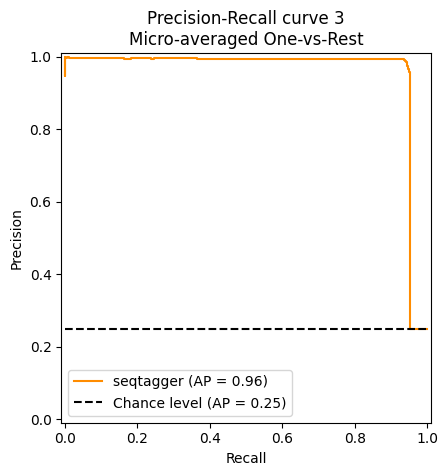

In [65]:
display = PrecisionRecallDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="seqtagger", color="darkorange", 
                                                  plot_chance_level=True)
_ = display.ax_.set(xlabel="Recall", ylabel="Precision", 
                    title="Precision-Recall curve {}\nMicro-averaged One-vs-Rest".format(i, len(y_score)))
fig = display.figure_

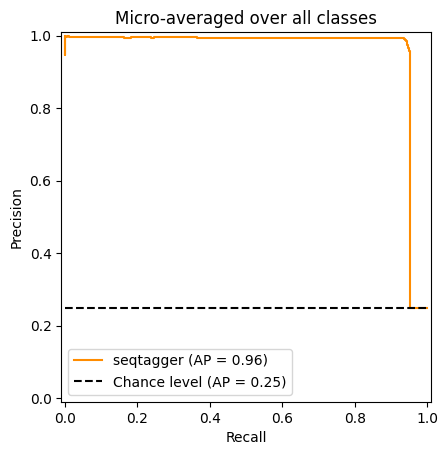

In [66]:
# For each class
precision, recall, average_precision = dict(), dict(), dict()
for i in range(y_score.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_onehot_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")
display = PrecisionRecallDisplay(recall=recall["micro"], precision=precision["micro"], average_precision=average_precision["micro"], 
                                 prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size)
display.plot(plot_chance_level=True, name="seqtagger", color="darkorange")
_ = display.ax_.set_title("Micro-averaged over all classes")

## deeplexicon

In [7]:
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/deeplexicon_std_fast5_pass_100k_batch{}/demux_table/deeplexicon_std_sample{}.txt"
df = pd.read_csv(fn.format(i, i), sep="\t")

CI = 0.9 # stringent

#n = int(df.barcode.max())
cm = np.zeros((n, n), dtype='int')
for idx, r in df.loc[df["Confidence Interval"]>=CI].iterrows():
    read_id = r.ReadID
    bc = int(r.Barcode.split("_")[-1])
    if read_id not in read2bc: continue
    cm[read2bc[read_id]-1, bc-1] += 1
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc, cm

(0.967,
 array([[11146,   244,   205,   117],
        [  118, 16785,   228,    91],
        [  194,   264, 28803,   183],
        [  462,   140,   137, 13684]]))

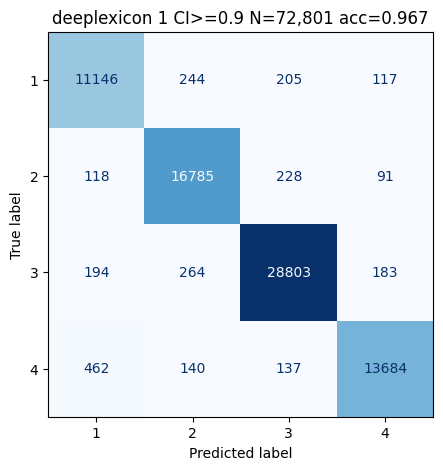

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sel = np.any((cm.sum(axis=0)!=0, cm.sum(axis=1)!=0), axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[sel][:,sel], 
                              display_labels=np.arange(1, len(cm)+1)[sel])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
title = "deeplexicon {} CI>={} N={:,} acc={:.3f}".format(i, CI, cm.sum(), acc)
ax.set_title(title)
fig.savefig("deeplexicon_{}.{}.confusion_matrix.{}".format(CI, i, ext))

In [9]:
bc2c = Counter(read2bc.values()); bc2c
c = np.array([[bc2c[k] for k in sorted(bc2c.keys())]]); c.T
missing = c-cm.sum(axis=1)
cm_with_missing = np.hstack((cm, missing.T))
np.savetxt(sys.stdout, cm_with_missing, fmt="%d", delimiter="\t")

11146	244	205	117	3983
118	16785	228	91	5403
194	264	28803	183	11513
462	140	137	13684	5127


12681	537	510	284	1683
432	18786	649	324	2434
676	916	33986	635	4744
1038	323	332	15680	2177


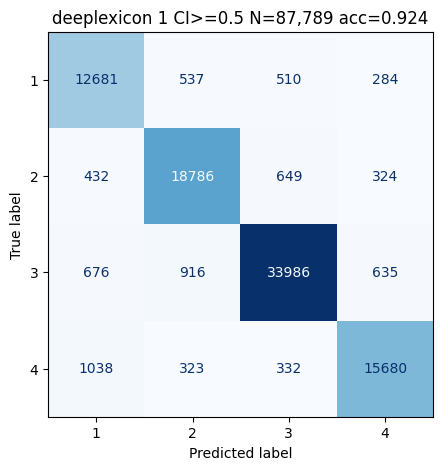

In [10]:
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/deeplexicon_std_fast5_pass_100k_batch{}/demux_table/deeplexicon_std_sample{}.txt"
df = pd.read_csv(fn.format(i, i), sep="\t")
CI = 0.5 # default

#n = int(df.barcode.max())
cm = np.zeros((n, n), dtype='int')
for idx, r in df.loc[df["Confidence Interval"]>=CI].iterrows():
    read_id = r.ReadID
    bc = int(r.Barcode.split("_")[-1])
    if read_id not in read2bc: continue
    cm[read2bc[read_id]-1, bc-1] += 1
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc, cm

fig, ax = plt.subplots(figsize=(5, 5))
sel = np.any((cm.sum(axis=0)!=0, cm.sum(axis=1)!=0), axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[sel][:,sel], 
                              display_labels=np.arange(1, len(cm)+1)[sel])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
title = "deeplexicon {} CI>={} N={:,} acc={:.3f}".format(i, CI, cm.sum(), acc)
ax.set_title(title)
fig.savefig("deeplexicon_{}.{}.confusion_matrix.{}".format(CI, i, ext))

bc2c = Counter(read2bc.values()); bc2c
c = np.array([[bc2c[k] for k in sorted(bc2c.keys())]]); c.T
missing = c-cm.sum(axis=1)
cm_with_missing = np.hstack((cm, missing.T))
np.savetxt(sys.stdout, cm_with_missing, fmt="%d", delimiter="\t")

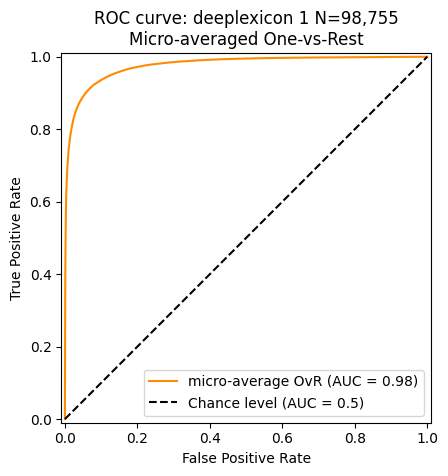

In [11]:
y_score = df[df.columns[-4:]].to_numpy(); y_score
y_test = np.array([read2bc[r] if r in read2bc else 0 for r in df.ReadID.to_numpy()]); y_test
y_score = y_score[y_test>0]
y_test = y_test[y_test>0]; y_test.shape, y_score.shape
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test); y_onehot_test

display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="micro-average OvR", color="darkorange", plot_chance_level=True)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
                    title="ROC curve: deeplexicon {} N={:,}\nMicro-averaged One-vs-Rest".format(i, len(y_score)))
fig = display.figure_
fig.savefig("deeplexicon.{}.ROC.{}".format(i, ext))


# confusion matrix and RoC RNA004

In [3]:
# https://crg-epitranscriptome.slack.com/archives/C04M6JCDV4L/p1708599454164299?thread_ts=1708508760.289069&cid=C04M6JCDV4L
ref2bc = {'cc6m_2244_T7_ecorv': 1,
 'cc6m_2459_T7_ecorv': 2,
 'cc6m_2595_T7_ecorv': 3,
 'cc6m_2709_T7_ecorv': 4, 
 '25s_5end_yrRNA_T7_BamHI': 1,
 'ALKBH5': 3,
 'KIAA1456': 4,
 'Apobec': 2,
}

i = "" # 1 2 3
ext = "svg"
bams = ["/no_backup/enovoa/nextflow_outputs/demux_comparison/results/b04_RNA004_ind_val_ground_truth/alignment/final_merge_s.bam", 
       ]; bams

read2bc = {}
for bi, bam in enumerate(bams, 1):
    sys.stderr.write(" %s / %s \r"%(bi, len(bams)))
    sam = pysam.AlignmentFile(bam)
    for a in sam:
        if a.is_secondary or a.mapq<20 or a.is_supplementary: #
            continue
        r, ref = a.qname, a.reference_name
        #if r not in read2ref: read2ref[r] = [(a.mapq, a.reference_name)]
        if ref not in ref2bc: continue
        read2bc[r] = ref2bc[ref]
print(len(read2bc), Counter(read2bc.values()))

2351298 Counter({3: 855695, 2: 766676, 4: 530958, 1: 197969})


In [4]:
fn = "/no_backup/enovoa/nextflow_outputs/demux_comparison/results/b04_RNA004_ind_val_ground_truth/demux_table/merged_seqtagger.tsv"
df = pd.read_csv(fn.format(i, i), sep="\t")

minbaseQ = 50
n = int(df.barcode.max())
cm = np.zeros((n, n), dtype='int')
for idx, r in df.loc[df.baseQ>=minbaseQ].iterrows():
    if r.read_id not in read2bc: continue
    if np.isnan(r.barcode): continue
    cm[read2bc[r.read_id]-1, int(r.barcode-1)] += 1
acc = np.round(np.diag(cm).sum()/cm.sum(), 3); acc, cm

(0.995,
 array([[188926,     60,    947,    629],
        [  2176, 735292,   1461,    981],
        [  1667,    561, 829742,    936],
        [  1816,    198,    694, 510919]]))

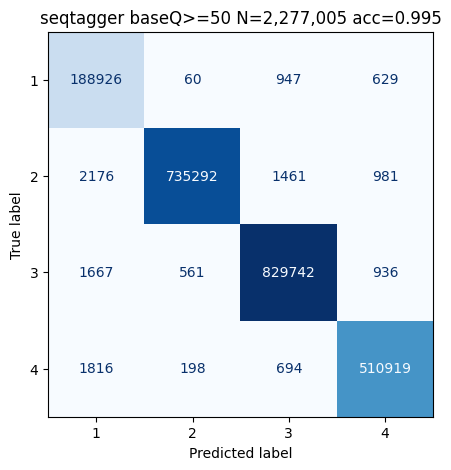

In [7]:
ext = "svg"
fig, ax = plt.subplots(figsize=(5, 5))
sel = np.any((cm.sum(axis=0)!=0, cm.sum(axis=1)!=0), axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[sel][:,sel], 
                              display_labels=np.arange(1, len(cm)+1)[sel])
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
runid = os.path.basename(fn)
title = "seqtagger baseQ>={} N={:,} acc={:.3f}".format(minbaseQ, cm.sum(), acc)
ax.set_title(title)
fig.savefig("seqtagger.confusion_matrix.{}".format(ext))
fig.savefig("seqtagger.confusion_matrix.pdf")

In [6]:
bc2c = Counter(read2bc.values()); bc2c
c = np.array([[bc2c[k] for k in sorted(bc2c.keys())]]); c.T
missing = c-cm.sum(axis=1)
cm_with_missing = np.hstack((cm, missing.T))
np.savetxt(sys.stdout, cm_with_missing, fmt="%d", delimiter="\t")

188926	60	947	629	7407
2176	735292	1461	981	26766
1667	561	829742	936	22789
1816	198	694	510919	17331


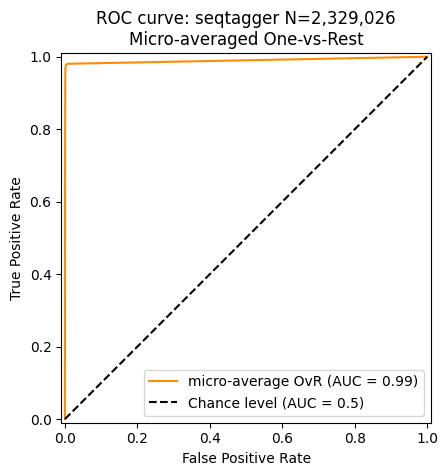

In [10]:
y_score = np.zeros((len(df), 4)); y_score.shape
for _i, (bc, score) in enumerate(zip(df.barcode.to_numpy(), df.baseQ.to_numpy())):
    y_score[_i, bc-1] = score
y_test = np.array([read2bc[r] if r in read2bc else 0 for r in df.read_id.to_numpy()]); y_test
y_score = y_score[y_test>0]
y_test = y_test[y_test>0]; y_test.shape, y_score.shape
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test); y_onehot_test

display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="micro-average OvR", color="darkorange", plot_chance_level=True)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate", 
                    title="ROC curve: seqtagger N={:,}\nMicro-averaged One-vs-Rest".format(len(y_score)))
fig = display.figure_
fig.savefig("seqtagger.ROC.{}".format(ext))
fig.savefig("seqtagger.ROC.pdf")

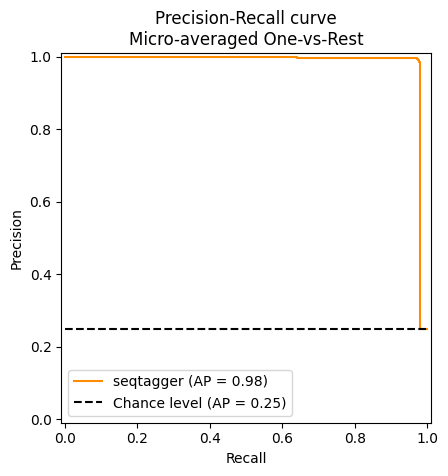

In [12]:
display = PrecisionRecallDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name="seqtagger", color="darkorange", 
                                                  plot_chance_level=True)
_ = display.ax_.set(xlabel="Recall", ylabel="Precision", 
                    title="Precision-Recall curve\nMicro-averaged One-vs-Rest".format(len(y_score)))
fig = display.figure_
fig.savefig("seqtagger.Precision-Recall.{}".format(ext))
fig.savefig("seqtagger.Precision-Recall.pdf")